**Code Flow**

1.   Use CK+ database with expression label and AU labels - *#309 images*
2.   Process the images to obtain frontal and uniform eye distance faces - *using facemask for test*
3.   Scale the obtained images to agreed resolution without distorting aspect-ratio

---

Alternating Optimization 

4.   Use Expression-AU relationship table#2 to initialize missing AU labels as 1 or 0
5.   Extract features and textures from processed images using local binary pattern - *sklearn module*
6.   Reduce dimensionality of the data using PCA/LDA/Adaboost/Gentleboost - *planned in next iteration*
7.   Train SVM classifier with linear kernel per Eq#21 - *L-BGFS planned in next iteration*
8.   After converging step#7, fix W using optimized values
9.   Start training again using Eq#22
10.   Find best AU config for each sample by Eq#20
11.   If Eq#20 minimized then replace AU config else don't
12.   Repeat step9-11 until all samples are best per Eq#20
13.   Repeat from step#7

Part2 of alternating optimization algo

1. For each training sample compute Eq#22 using the loss equations but how to estimate penalty factors ? using gridsearchcv ?
example for S005_001_00000011.png-4,9,10,17 we will compute eq#22 for AU4 classifier - same to be repeated for 9,10,17
1a. but how to minimize Eq#22 once derived using the probabilty losses (iterate 2powerm)
1b. how to estimate penalty factors from specified range (ask q to author)
1c. M in Eq#22 is total #AU classifier trained jointly or #AUs identified/estimated in a sample ?
1d. considering Eq#7 "Expr indp joint prob" calculation, where to look for "Pi1j1 - the estimated joint probability of co-occurrence" ? use derivation on dataset as stated below eq#7 for joint & single ?
1e. how to implement eq#12 ?
1f. any best practices while calculating estimated probabilities on training dataset to be used ?
2. Repeat step#1 for all training samples but how to minimize eq#22 ?
3. assuming best AU config for each sample using eq#22, how to minimize eq#20 ? how to estimate penalty factors ?
4. compare eq#20 o/p for each sample and select the minimum one 
5. update AU config of step#4 and leave the rest
6. repeat step2-5 until no further reduction in eq#20 o/p for samples
7. repeat part#1=>steps#1-6 until no convergence




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls 'drive/MyDrive/AIHealthcare/AUU'

In [ ]:
%cd drive/MyDrive/AIHealthcare/AUU

/content/drive/MyDrive/AIHealthcare/AUU


In [ ]:
def download_dataset_to_collab(dataset):
  '''
  Google Drive is a tag-based (also called semantic) file system, which, for example, allows a file to be in several places at the same time 
  (just by adding IDs of folders to the file's parents property)
  Hence to get the file/folder ID, navigate to the folder using browser & note the ID from URL 
  Ex: https://drive.google.com/drive/folders/1mZVxppM8dHFcoKdc9Vu9vS-n_GGnpCkO
  '''
  #Code to download files from google drive to collab using Pydrive

  !pip install -U -q PyDrive

  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  import time

  # 1. Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  # Auto-iterate through all files in the folder ID.
  start = time.time()
  for key, value in dataset.items():
    print("Initiating files copy from {} ...".format(key))
    if('dir' in key):
      file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(value)}).GetList()      #file_list = drive.ListFile({'q': "'1czmCOb4w0LiWetvQyhIxi6gGvJuAYb5F' in parents and trashed=false"}).GetList()
      for file1 in file_list:      
        file6 = drive.CreateFile({'id': file1['id']}) # Initialize GoogleDriveFile instance with file id.
        file6.GetContentFile(file1['title'])          # Download file as file1['title']
    else:
        fileId = drive.CreateFile({'id': value})
        print(type(value))
        print(fileId)
        print('title: %s, mimeType: %s' % (fileId['title'], fileId['mimeType']))
        fileId.GetContentFile(fileId['title'])
    print("Completed files copy from {}.".format(key))

  end = time.time()                                                                
  return 'time taken:'+ str(end-start) +'seconds'

dataset = {
          #'<file/folder_name>':'<gdrive_folder_id>'
          'dir1':'1ofsIjkg47c0GtFiTCEnyMN_QKrxQG93q',
          'dir2':'1_ipqV9ISrHTVDxJS3WX_VKPJQ4P0JZgP',
          'file1':'1PpeI6Rly8NaSMjHbnrP259sWo0Xzxt1J',
          'file2':'1RI-ZTABI0-zfeC5RyM3io5BXqbflLoHV'
          }

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
import itertools, time
!pip install xlrd
download_dataset_to_collab(dataset)
!mkdir -p datalab/img
!mv *.png datalab/img
tick = time.time()
!pwd
!ls -l
!ls datalab/img | wc -l
tock = time.time()
print(tock-tick)

Initiating files copy from dir2 ...
Completed files copy from dir2.
Initiating files copy from dir1 ...
Completed files copy from dir1.
Initiating files copy from file1 ...
<type 'str'>
GoogleDriveFile({'id': '1PpeI6Rly8NaSMjHbnrP259sWo0Xzxt1J'})
title: au4_svm.csv, mimeType: text/csv
Completed files copy from file1.
Initiating files copy from file2 ...
<type 'str'>
GoogleDriveFile({'id': '1RI-ZTABI0-zfeC5RyM3io5BXqbflLoHV'})
title: Probabilities.xlsx, mimeType: application/vnd.openxmlformats-officedocument.spreadsheetml.sheet
Completed files copy from file2.
/content/drive/My Drive/AIHealthcare/AUU
total 52
-rw------- 1 root root  6490 Mar  7 09:58 au4_svm.csv
drwx------ 3 root root  4096 Mar  7 09:58 datalab
-rw------- 1 root root 42383 Mar  7 09:58 Probabilities.xlsx
309
0.898237943649


In [ ]:
#http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean
from skimage.transform import resize, pyramid_reduce
from skimage.io import imread, imsave
import numpy as np

#https://stackoverflow.com/questions/44650888/resize-an-image-without-distortion-opencv
def scale_img_to_sqaure(img_abs_path, square_size):

  image = np.asarray(imread(img_abs_path))/255.0
  file_name = img_abs_path.split('/')[-1]

  height, width = image.shape    
  if(height > width):
    differ = height
  else:
    differ = width
  differ += 4

  # square filler
  mask = np.zeros((differ, differ), dtype = "float64")

  x_pos = int((differ - width) / 2.0)
  y_pos = int((differ - height) / 2.0)

  # center image inside the square
  mask[y_pos: y_pos + height, x_pos: x_pos + width] = image[0: height, 0: width]

  # downscale if needed
  if differ / square_size > 1:
    mask = pyramid_reduce(mask, differ / square_size)
  else:
    mask = cv2.resize(mask, (square_size, square_size), interpolation = cv2.INTER_AREA)
  imsave(file_name,mask)
  return mask  

# sq = scale_img_to_sqaure('/content/datalab/img/S037_003_00000022.png',96)

In [ ]:
ls 'datalab/img/S052_004_00000033.png'

In [ ]:
!cp datalab/img/S052_004_00000033.png /content/

In [ ]:
ls /content/drive/MyDrive/AIHealthcare/AUU/datalab/img/

93
22.0


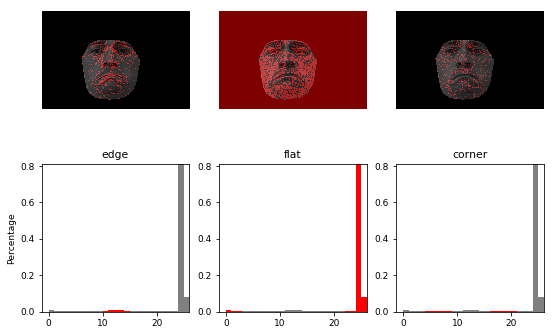

In [ ]:
#https://www.bytefish.de/blog/local_binary_patterns/
#http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb
import numpy as np
import matplotlib.pyplot as plt


METHOD = 'uniform'
plt.rcParams['font.size'] = 9

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


# image = data.load('/content/datalab/img/S052_004_00000033.png')
# image = data.load('/datalab/img/S052_004_00000033.png')
image = data.load('/content/drive/MyDrive/AIHealthcare/AUU/datalab/img/S506_006_00000042.png')

print(image[200,250])
lbp = local_binary_pattern(image, n_points, radius, METHOD)
print(lbp[200,250])

def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), normed=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(ymax=np.max(counts[:-1]))
    ax.set_xlim(xmax=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')
#print(list(W))

In [ ]:
ls '/content/drive/MyDrive/AIHealthcare/AUU/Probabilities.xlsx'

/content/drive/MyDrive/AIHealthcare/AUU/Probabilities.xlsx


In [ ]:
import os
import csv 
from skimage import data
from skimage.io import imsave, imshow
from matplotlib import pyplot as plt
from sklearn import svm, metrics, linear_model

def get_au_label(csvfile, imgfile):
  
  with open(csvfile, 'r') as f:
    r = csv.reader(f, delimiter=' ', quotechar='|')
    for row in r:
      if imgfile in row[0]:
        name,value=row[0].split(',')
        return int(value)

def get_au_label1(img,au):
  # dataset = pd.ExcelFile('/content/Probabilities.xlsx')
  dataset = pd.ExcelFile('/content/drive/MyDrive/AIHealthcare/AUU/Probabilities.xlsx')
  probabilities = dataset.parse(0)
  temp = probabilities.iloc[:,[0,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]]
  return int(temp[(temp['File']==img)][au].values[0])

def get_expr_label(img):
  # dataset = pd.ExcelFile('/content/Probabilities.xlsx')
  dataset = pd.ExcelFile('/content/drive/MyDrive/AIHealthcare/AUU/Probabilities.xlsx')
  probabilities = dataset.parse(0)
  temp = probabilities.iloc[:,[0,3]]
  return str(temp[(temp['File']==img)]['Expressions'].values[0])

def get_lbp(img_path):

  # settings for LBP
  radius = 3
  n_points = 8 * radius
  METHOD = 'uniform'

  image = data.load(img_path)
  return local_binary_pattern(image, n_points, radius, METHOD)

def img_to_vector(path,au):
  
  X_train = np.ndarray(shape=(len(os.listdir(path)), 101, 101), dtype=np.float64)
  Y_train = np.ndarray(shape=len(os.listdir(path)),dtype=np.float16)
  X_expr = []
  i=0
  for img in os.listdir(path):
    s,t = img.split('.')  
    Y_train[i] = get_au_label1(s,au)
    X_expr.append(get_expr_label(s))
    sq_img = scale_img_to_sqaure(path+str(img), 96)
    X_train[i] = get_lbp('/content/'+str(img))
    i += 1
  return X_train,Y_train, X_expr

def train_svc(X, y, x_test):  
  clf = svm.LinearSVC(random_state=0)
  clf.fit(X, y)  
  svm.LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=0, tol=0.0001, verbose=1)
  return clf

In [ ]:
ls '/content/drive/MyDrive/AIHealthcare/AUU/datalab/img/'

In [ ]:
def eq21_training(y_new, au_list):
  i=0
  W = np.ndarray(shape=(269, 10201), dtype=np.float64)
  for au in au_list:
    tick = time.time()
    X_train, Y_train, X_expr = img_to_vector("/content/drive/MyDrive/AIHealthcare/AUU/datalab/img/",au)
    Y_train = np.transpose(y_new[:,i])
      
    #Flatten the image vectors for SVM classifier 
    # - https://stackoverflow.com/questions/33162871/python-scikit-learn-svm-classifier-valueerror-found-array-with-dim-3-expected/35005672
    # - https://www.kaggle.com/halien/simple-image-classifer-with-svm

    X = X_train[0:269,:,:].reshape(269,-1)
    y = Y_train[0:269,]
    x_expr = X_expr[0:269]
    x_test = X_train[270:,:,:].reshape(39,-1)
    y_test = Y_train[270:,]

    classifier = train_svc(X, y, x_test)
    y_pred = classifier.predict(x_test)
    confidence = classifier.decision_function(x_test)
    #Coeeficients: (1, 10201)
    W[i,:]=classifier.coef_
    print(classifier.coef_)
    print(W[i])
    i += 1

    print('*************AU{} Classifier*************'.format(au))
    print('Pred: {}'.format(y_pred))
    print('Test: {}'.format(y_test))
    print('AU{} classifier co-eficients: {}'.format(au,classifier.coef_.shape))
    print("Classification report for classifier {}, {}".format(classifier, metrics.classification_report(y_test, y_pred)))
    print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))
    tock = time.time()
    print(tock-tick)
  return W, X, x_expr

In [ ]:
#Express independent joint AU probability loss
def eq8_loss(test_au_labels, positive_au_pairs, negative_au_pairs):
  pt_loss = nt_loss = 0
  '''positive_au_pairs = [i for i in positive_au_pairs if set(i)<=set(test_au_labels)]
  negative_au_pairs = [i for i in negative_au_pairs if set(i)<=set(test_au_labels)]
  print(positive_au_pairs)
  print(negative_au_pairs)
  for pt_pair in positive_au_pairs:
    prob_i = get_prob_i(pt_pair[0])
    prob_j = get_prob_i(pt_pair[1])
    prob_ij = get_prob_ij(pt_pair)
    print('prob_i'+str(prob_i))
    print('prob_j'+str(prob_j))
    print('prob_ij'+str(prob_ij))
    pt_loss += max(0,(prob_i*prob_j - prob_ij)) + max(0,((1-prob_i)*prob_j - prob_ij)) + max(0,(prob_i*(1-prob_j) - prob_ij))'''
  
  ## Determine the positive pairs not occurring together
  positive_au_pairs_not_present = list()
  for i in test_au_labels:
    for j in positive_au_pairs:
      if i in j:
        if not ((j[0] in test_au_labels) and (j[1] in test_au_labels)):
          positive_au_pairs_not_present.append(j)
  ######################################################
  
  for pt_pair in positive_au_pairs_not_present:
    prob_i = get_prob_i(pt_pair[0])
    prob_j = get_prob_i(pt_pair[1])
    prob_ij = get_prob_ij(pt_pair)
    pt_loss += max(0,(prob_i*prob_j - prob_ij)) + max(0,((1-prob_i)*prob_j - prob_ij)) + max(0,(prob_i*(1-prob_j) - prob_ij))
    
  negative_au_pairs = [i for i in negative_au_pairs if set(i)<=set(test_au_labels)]
  for nt_pair in negative_au_pairs:
      prob_i = get_prob_i(nt_pair[0])
      prob_j = get_prob_i(nt_pair[1])
      prob_ij = get_prob_ij(nt_pair)
      nt_loss += max(0,(prob_ij - prob_i*prob_j)) + max(0,(prob_ij - (1-prob_i)*prob_j)) + max(0,(prob_ij - prob_i*(1-prob_j)))
  return (pt_loss+nt_loss)

#Expression dependent single AU probability loss - considering only 'primary'/'others' AU - SUMMATE over K
def eq11_loss(test_au_labels, x_expr_label, primary_au, others_au):
  loss=0
  for pr_au in primary_au[x_expr_label]:
    if pr_au not in test_au_labels:
      prob_i_k = get_prob_i_under_k(pr_au, x_expr_label)
      loss += max(0,(0.5 - prob_i_k))
  for ot_au in others_au[x_expr_label]:
    if ot_au in test_au_labels:
      prob_i_k = get_prob_i_under_k(ot_au, x_expr_label)
      loss += max(0,(prob_i_k - 0.5))    
  return loss

#Expression dependent single AU probability loss - calculating differences wrt table3
def eq13_loss():
  return loss

#Expression dependent joint AU probability loss - (prob_primary > prob_secondary) & (prob_secondary > prob-others)
def eq15_loss(test_au_labels, emotion_list, primary_secondary_au_pairs, secondary_others_au_pairs):
  loss = 0
  #Filter primary_secondary_au_pairs 
  for e in emotion_list:
    primary_secondary_au_pairs[e] = [i for i in primary_secondary_au_pairs[e] if i[1] in test_au_labels and i[0] not in test_au_labels]
    secondary_others_au_pairs[e] = [i for i in secondary_others_au_pairs[e] if i[1] in test_au_labels and i[0] not in test_au_labels]
  for e in emotion_list:
    for ps in primary_secondary_au_pairs[e]:
      prob_prim = get_prob_i_under_k(ps[0], e)
      prob_sec = get_prob_i_under_k(ps[1], e)
      loss += max(0,(prob_sec - prob_prim))
    for ps in secondary_others_au_pairs[e]:
      prob_sec = get_prob_i_under_k(ps[0], e)
      prob_oth = get_prob_i_under_k(ps[1], e)        
      loss += max(0,(prob_oth - prob_sec))
  return loss

#Expression dependent joint AU probability loss - positive correlation per table4 - SUMMATE over K
def eq19_loss(test_au_labels, emotion_list, emfacs):
  loss = 0
  #Filter emfacs
  '''for e in emotion_list:
    emfacs[e] = [i for i in emfacs[e] if set(i)<=set(test_au_labels)]'''
  #Filter emfacs
  emfacs_pairs_not_present = defaultdict(list)
  for e in emotion_list:
    for i in test_au_labels:
      for j in emfacs[e]:
        if i in j:
          if not ((j[0] in test_au_labels) and (j[1] in test_au_labels)):
            emfacs_pairs_not_present[e].append(j)
  
  emfacs_pairs_not_present = dict(emfacs_pairs_not_present)
  for e in emotion_list:
    if e in emfacs_pairs_not_present:
      for ps in emfacs_pairs_not_present[e]:
        prob_i_k = get_prob_i_under_k(ps[0], e)
        prob_j_k = get_prob_i_under_k(ps[1], e)
        prob_ij_k = get_prob_ij_under_k(ps, e)
        loss += max(0,(prob_i_k*prob_j_k - prob_ij_k)) + max(0,((1-prob_i_k)*prob_j_k - prob_ij_k)) + max(0,(prob_i_k*(1-prob_j_k) - prob_ij_k))
    else:
      pass
  return loss

#plan to use code to estimate optimum value for each lambda but for getting ahead assuming all to be 10 from range {10, 10^2, 10^3, 10^4}  
def lambda_optimization():  
  lambd_eq8=lambd_eq13=lambd_eq19=lambd_eq15 = 10
  lambda_eq11 = 100
  return lambd_eq8, lambda_eq11, lambd_eq13, lambd_eq19, lambd_eq15

#Calculate hinge loss
def hinge_loss(y, x, w):
  return max(0,(1 - (y*(np.dot(np.transpose(w),x)))))

#Calculate classification loss
def classification_loss(au_config, x, W):
  clf_loss = 0
  for m in range(len(au_config)):
    w = W[m,:]
    y = au_config[m]
    clf_loss += hinge_loss(y, w, x)
  return clf_loss

def eq22_loss(test_au_config, x, W, x_expr_label, au_list, primary_au, secondary_au, others_au, positive_au_pairs, negative_au_pairs, emotion_list):  

  M = len(au_list)
  au_test_config_arr = np.array(list(itertools.product([0, 1], repeat=M)))
  lambd_eq8, lambda_eq11, lambd_eq13, lambd_eq19, lambd_eq15 = lambda_optimization()
  primary_secondary_au_pairs = pairs_from_dictionaries(primary_au, secondary_au, emotion_list)
  secondary_others_au_pairs = pairs_from_dictionaries(secondary_au, others_au, emotion_list)
  test_au_labels = au_label_list(au_list, test_au_config)
  
  total_loss = Loss_eq8 = Loss_eq11 = Loss_eq13 = Loss_eq15 = Loss_eq19 = 0

  #Classification loss calculations
  clf_loss = classification_loss(test_au_config, x, W)

  
  #Loss_eq8
  Loss_eq8 = lambd_eq8 * eq8_loss(test_au_labels, positive_au_pairs, negative_au_pairs)

  #Loss_eq11      
  Loss_eq11 = lambda_eq11 * eq11_loss(test_au_labels, x_expr_label, primary_au, others_au)

  #Loss_eq15
  Loss_eq15 = lambd_eq15 * eq15_loss(test_au_labels, emotion_list, primary_secondary_au_pairs, secondary_others_au_pairs)

  #Loss_eq19
  Loss_eq19 = lambd_eq19 * eq19_loss(test_au_labels, emotion_list, emfacs_pairs)

  print('clf_loss:{} eq8_loss:{} eq11_loss:{} eq13_loss:{} eq15_loss:{} eq19_loss:{}'.format(clf_loss,Loss_eq8,Loss_eq11,Loss_eq13,Loss_eq15,Loss_eq19))
  total_loss = (clf_loss + Loss_eq8 + Loss_eq11 + Loss_eq13 + Loss_eq15 + Loss_eq19)/M
  return total_loss

def get_eq22_best_AU_config(au_test_config_arr, x, sample_no, x_expr_label, W, au_list, primary_au, secondary_au, others_au, positive_au_pairs, negative_au_pairs, emotion_list):
  min_loss = None
  y_eq22_best = au_test_config_arr[0]
  for test_au_config in au_test_config_arr:
    tick=time.time()
    x_loss = eq22_loss(test_au_config, x, W, x_expr_label, au_list, primary_au, secondary_au, others_au, positive_au_pairs, negative_au_pairs, emotion_list)
    if min_loss == None:
      min_loss = x_loss  
    if x_loss < min_loss:
      min_loss = x_loss
      y_eq22_best = test_au_config
    tock=time.time()
    print('sample: {} x_loss: {} for {} min_loss: {} for {} under {}s'.format(sample_no, x_loss,test_au_config,min_loss,y_eq22_best,(tock-tick)))
  return y_eq22_best

def compute_eq20_obj(best_au_config, X, W, x_expr_label, y_new, au_list, primary_au, secondary_au, others_au, positive_au_pairs, negative_au_pairs, emotion_list):

  M = len(au_list)
  lambd_eq8, lambda_eq11, lambd_eq13, lambd_eq19, lambd_eq15 = lambda_optimization()
  primary_secondary_au_pairs = pairs_from_dictionaries(primary_au, secondary_au, emotion_list)
  secondary_others_au_pairs = pairs_from_dictionaries(secondary_au, others_au, emotion_list)
  test_au_labels = au_label_list(au_list, best_au_config)
  
  main_obj = Loss_eq8 = Loss_eq11 = Loss_eq13 = Loss_eq15 = Loss_eq19 = 0

  #Classification loss calculations
  for sample in range(y_new.shape[0]):
    x=X[sample]
    clf_loss = classification_loss(np.transpose(y_new[sample,:]), x, W)
 
  #Loss_eq8
  Loss_eq8 = lambd_eq8 * eq8_loss(test_au_labels, positive_au_pairs, negative_au_pairs)

  #Loss_eq11      
  Loss_eq11 = lambda_eq11 * eq11_loss(test_au_labels, x_expr_label, primary_au, others_au)

  #Loss_eq15
  Loss_eq15 = lambd_eq15 * eq15_loss(test_au_labels, emotion_list, primary_secondary_au_pairs, secondary_others_au_pairs)

  #Loss_eq19
  Loss_eq19 = lambd_eq19 * eq19_loss(test_au_labels, emotion_list, emfacs_pairs)

  main_obj = (clf_loss + Loss_eq8 + Loss_eq11 + Loss_eq13 + Loss_eq15 + Loss_eq19)/M
  return main_obj

In [ ]:
#Convert binary AU config array to AU label array
def au_label_list(au_list, au_config):
  M = len(au_list)
  au_labels=[]
  for m in range(M):
    if au_config[m] == 1:
      au_labels.append(au_list[m])
  return au_labels

#Get all pairs of items from dictionaries in specified order
def pairs_from_dictionaries(dict1, dict2, emotion_list):
  pairs_dict1_dict2 = {}
  for e in emotion_list:
    list_of_pairs = []
    for x in dict1[e]:
      for y in dict2[e]:
        list_of_pairs.append([x,y])
    pairs_dict1_dict2[e] = list_of_pairs
  return pairs_dict1_dict2
  
#Get expression independent marginal AU probability that is calculated from dataset
def get_prob_i(au):
  dataset = pd.ExcelFile('/content/drive/MyDrive/AIHealthcare/AUU/Probabilities.xlsx')
  probabilities = dataset.parse(0)
  probabilities = probabilities.iloc[:,4:]
  n_array = probabilities.values

  indi_prob_dict = defaultdict()
  columns = list(probabilities.columns)
  individualProbabilities = np.sum(n_array,axis=0)/309.0
  for index,value in enumerate(columns):
      indi_prob_dict[value] = individualProbabilities[index]

  return indi_prob_dict[au]

#Get expression independent marginal AU probability that is calculated from dataset
def get_prob_ij(au_pair):
  dataset = pd.ExcelFile('/content/drive/MyDrive/AIHealthcare/AUU/Probabilities.xlsx')
  probabilities = dataset.parse(0)
  probabilities = probabilities.iloc[:,4:]
  n_array = probabilities.values
  
  joint_prob_dict_11 = defaultdict()
  columns = list(probabilities.columns)
  for cols in itertools.combinations(range(18),2):
      temp = n_array[:,cols]
      (x,y) = columns[cols[0]],columns[cols[1]]
      #print(temp),.
      temp_11 = temp[ (temp[:,0]==1) & (temp[:,1]==1)]
      joint_prob_dict_11[(x,y)] = temp_11.shape[0]/309.0
  return joint_prob_dict_11[au_pair]

#Get expression dependent marginal AU probability that is calculated from dataset
def get_prob_i_under_k(au, emotion):
  dataset = pd.ExcelFile('/content/drive/MyDrive/AIHealthcare/AUU/Probabilities.xlsx')
  probabilities = dataset.parse(0)
  probabilities = probabilities.iloc[:,3:]
  n_array = probabilities.values
  columns = list(probabilities.columns)[1:]

  expressions = ['disgust','surprise','anger','happiness','sadness','fear']
  primary_aus = {'disgust':[9,10],'surprise':[1,2,5,25,26],'anger':[4,5,23,24],'happiness':[6,12],'sadness':[1,7,15],'fear':[1,2,4,5,7,20]}
  secondary_aus = {'disgust':[17,25],'surprise':[16],'anger':[7,17],'happiness':[7,25],'sadness':[4,6,17],'fear':[23,25]}
  nested_dict = lambda: defaultdict(nested_dict)
  master_aus_prob = nested_dict()
  for i in expressions:
      temp_expr = probabilities[(probabilities['Expressions']==i)]
      temp_aus = temp_expr.iloc[:,1:].values
      for j in columns:
          index_au = columns.index(j)
          master_aus_prob[i][j] = np.sum(temp_aus[:,index_au],axis=0)/float(temp_aus.shape[0])
  return master_aus_prob[emotion][au]

#Get expression dependent joint AU probability that is calculated from dataset
def get_prob_ij_under_k(au_pair, emotion):
  dataset = pd.ExcelFile('/content/drive/MyDrive/AIHealthcare/AUU/Probabilities.xlsx')
  probabilities = dataset.parse(0)
  probabilities_expressions = probabilities.iloc[:,3:]
  n_array = probabilities.values
  n_array_expr = probabilities_expressions.values
  columns = list(probabilities.columns)[4:]

  #dependent_aus = {'anger':[(4,5),(4,7),(4,5,7),(17,24),(23,)],'disgust':[(9,),(10,)],'fear':[(1,2,4),(20,)],'happiness':[(12,),(6,12),(7,12)],'sadness':[(1,),(1,4),(15,),(6,15)],'surprise':[(1,2,5),(1,2,26),(1,2,5,26)]}
  dependent_aus = {'anger':[(4,5),(4,7),(17,24)],'disgust':[],'fear':[(1,2), (1,4), (2,4)],'happiness':[(6,12),(7,12)],'sadness':[(1,4), (6,15)],'surprise':[(1,2), (1,5), (2,5), (2,26), (1,26), (1,5), (5,26)]}
  nested_dict = lambda: defaultdict(nested_dict)
  dependent_aus_prob = nested_dict()
  for i in dependent_aus:
      temp_expr = probabilities_expressions[(probabilities_expressions['Expressions']==i)]
      temp_aus = temp_expr.iloc[:,1:].values
      for j in dependent_aus[i]:
          j1 = [columns.index(x) for x in j]
          temp = temp_aus[:,j1]
          dependent_aus_prob[i][j] = temp.tolist().count([1]*temp.shape[1])/float(temp_aus.shape[0])
  return dependent_aus_prob[emotion][au_pair]

In [ ]:
#AU list considered in our solution derived from table2 - 17 AUs
au_list = [1,2,4,5,6,7,9,10,12,15,16,17,20,23,24,25,26,27]
#au_list = [1,2,4,5,6,7,9,12,15,17,20,23,24,26]
#au_list = [1,2,4,6,7,9,12,15,17,23,24]
# au_list = [1,2,4,6,7]
emotion_list = ["anger","disgust","fear","happiness","sadness","surprise"]
primary_au = {
              "anger": [4,5,23,24],
              "disgust": [9,10],
              "fear": [1,2,4,5,7,20],
              "happiness": [6,12],
              "sadness": [1,7,15],
              "surprise": [1,2,5,25,26]
              }
secondary_au = {
              "anger": [7,17],
              "disgust": [17,25],
              "fear": [23,25],
              "happiness": [7,25],
              "sadness": [4,6,17],
              "surprise": [16]
}
others_au = {
              "anger": [1, 2, 6, 9, 10, 12, 15, 16, 20, 25, 26],
              "disgust": [1, 2, 4, 5, 6, 7, 12, 15, 16, 20, 23, 24, 26],
              "fear": [6, 9, 10, 12, 15, 16, 17, 24, 26],
              "happiness": [1, 2, 4, 5, 9, 10, 15, 16, 17, 20, 23, 24, 26],
              "sadness": [2, 5, 9, 10, 12, 16, 20, 23, 24, 25, 26],
              "surprise": [4, 6, 7, 9, 10, 12, 15, 17, 20, 23, 24]
}

#Expression independent FACS encoded AU pairs
positive_au_pairs = [(1,2), (4,7) , (4,9), (7,9), (6,12), (9,17), (15,17), (15,24), (17,24), (23,24)]
negative_au_pairs = [(2,6), (2,7), (12,15), (12,17)]

#derived from emfacs table4 - pairing two-wise
emfacs_pairs = {
          "anger": [(4,5), (4,7), (17,24)],
          "disgust": [],
          "fear": [(1,2), (1,4), (2,4)],
          "happiness": [(6,12), (7,12)],
          "sadness": [(1,4), (6,15)],
          "surprise": [(1,2), (1,5), (2,5), (2,26), (1,26), (1,5), (5,26)]
}

#generate list of test AU configs
au_test_config_arr = np.array(list(itertools.product([0, 1], repeat=len(au_list))))
print(au_test_config_arr.shape)
s = np.sum(au_test_config_arr,1)
del_list=[]
for x in range(s.shape[0]):
  if s[x] <= 1:
    del_list.append(x)
print(del_list)
au_test_config_arr = np.delete(au_test_config_arr, del_list, 0)

(262144, 18)
[0, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]


In [ ]:
#Complete code - run from here
main_obj = min_obj = 100000
au_list = [1,2,4,5,6,7,9,10,12,15,16,17,20,23,24,25,26,27]
# au_list = [1,2,4]

def init_y():
  #Initialize y from table2
  y_new = np.ndarray(shape=(269, len(au_list)), dtype=np.int)
  dataset = pd.ExcelFile('/content/drive/MyDrive/AIHealthcare/AUU/Probabilities.xlsx')
  probabilities = dataset.parse(0)
  temp = probabilities.iloc[:,[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]]
  #temp = probabilities.iloc[:,[4,5,6]]
  y_new = temp.values
  return y_new

def core_algo(y_new, au_list, min_obj):
  
  #step1 train linear SVM: fix Y, optimize W
  W, X, x_expr = eq21_training(y_new, au_list)
  
  #step2 greedy algo: fix W, optimize Y
  for i in range(X.shape[0]):
    x=X[i]
    x_expr_label = x_expr[i]
    #step4 find best AU config for a sample (tried parallelize but causing issue in numpy array)
    y_temp = get_eq22_best_AU_config(au_test_config_arr, x, i, x_expr_label, W, au_list, primary_au, secondary_au, others_au, positive_au_pairs, negative_au_pairs, emotion_list)
    print('eq22_config for sample{} is {}'.format(i,y_temp))
    #compute eq20_obj for above sample
    x_obj = compute_eq20_obj(y_temp, X, W, x_expr_label, y_new[0:269,:], au_list, primary_au, secondary_au, others_au, positive_au_pairs, negative_au_pairs, emotion_list)
    print('min_eq20_obj before sample{} is {}'.format(i,min_obj))
    print('eq20_obj for sample{} is {}'.format(i,x_obj))
    if x_obj < min_obj:
      min_obj = x_obj
      y_new[i] = y_temp          #replace y[i]

  return y_new, min_obj

if __name__ == "__main__":
  y_new = init_y()
  y_new, main_obj = core_algo(y_new, au_list, main_obj)
  while (main_obj - min_obj) > 0.001:
      y_new, min_obj = core_algo(y_new, au_list, min_obj)
      print(main_obj, min_obj)
      if min_obj < main_obj:
        main_obj = min_obj
        min_obj = 0